# Import and Costants

In [1]:
!pip install -q tf-models-official
!pip install -q -U tensorflow-text 

     |████████████████████████████████| 2.1 MB 29.2 MB/s 
     |████████████████████████████████| 116 kB 70.3 MB/s 
     |████████████████████████████████| 1.3 MB 47.9 MB/s 
     |████████████████████████████████| 4.6 MB 59.3 MB/s 
     |████████████████████████████████| 99 kB 10.2 MB/s 
     |████████████████████████████████| 352 kB 64.7 MB/s 
     |████████████████████████████████| 1.1 MB 49.3 MB/s 
     |████████████████████████████████| 636 kB 73.7 MB/s 
     |████████████████████████████████| 511.7 MB 5.6 kB/s 
     |████████████████████████████████| 238 kB 72.7 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.6 MB 52.1 MB/s 
     |████████████████████████████████| 438 kB 71.7 MB/s 
     |████████████████████████████████| 5.8 MB 60.6 MB/s 


In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
import numpy as np
import pandas as pd
from tensorflow import keras
import os
import shutil
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from google.colab import drive
from gensim.models import Word2Vec
from collections import Counter
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_hub as hub
import tensorflow_text as text  # Registers the ops.


# Connection to Google Drive

In [13]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
%run /content/gdrive/Shareddrives/CyberBullyingClassification/utilities.ipynb

# Dataset loading
We load the dataset and prepare it for the training.

In [6]:
train_ds, val_ds, test_ds = load_data_splits()
x_train, y_train, x_val, y_val, x_test, y_test = get_data_and_labels(train_ds, val_ds, test_ds)

In [7]:
MAX_LENGTH = 350 # max len of representation of a tweet
MAX_WORDS = 25000 # max size of vocabulary

We load the embedding matrices and we create the tensors to use for the training.

In [8]:
y_train = np.asarray(y_train).astype('float32')
y_val = np.asarray(y_val).astype('float32')
y_test = np.asarray(y_test).astype('float32')

#Bert model

In [ ]:
BERT_MODEL="https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
BERT_PREPROCESS_MODEL="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
text_input = layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(BERT_PREPROCESS_MODEL, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
  
encoder = hub.KerasLayer(BERT_MODEL, trainable=False, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = layers.Dropout(0.1)(net)
net = layers.Dense(128,activation = "relu")(net)
net = layers.Dropout(0.1)(net)
net = layers.Dense(len(CLASSES), activation="softmax", name='classifier')(net)
  
model = tf.keras.Model(text_input, net, name = "BertBase_Freezed")

model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "BertBase_Freezed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                       

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.2336 - accuracy: 0.5462
Epoch 1: val_loss improved from inf to 1.00341, saving model to model/BertBase_Freezed.h5
109/109 [==============================] - 296s 3s/step - loss: 1.2336 - accuracy: 0.5462 - val_loss: 1.0034 - val_accuracy: 0.6461
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 1.0181 - accuracy: 0.6417
Epoch 2: val_loss improved from 1.00341 to 0.95541, saving model to model/BertBase_Freezed.h5
109/109 [==============================] - 291s 3s/step - loss: 1.0181 - accuracy: 0.6417 - val_loss: 0.9554 - val_accuracy: 0.6705
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.9655 - accuracy: 0.6595
Epoch 3: val_loss improved from 0.95541 to 0.93187, saving model to model/BertBase_Freezed.h5
109/109 [==============================] - 291s 3s/step - loss: 0.9655 - accuracy: 0.6595 - val_loss: 0.9319 - val_accuracy: 0.6715
Epoch 4/50
109/109 [==================

INFO:tensorflow:Assets written to: ram://844de0c1-2349-4f98-bf8e-aeac17d96ee1/assets


INFO:tensorflow:Assets written to: ram://844de0c1-2349-4f98-bf8e-aeac17d96ee1/assets


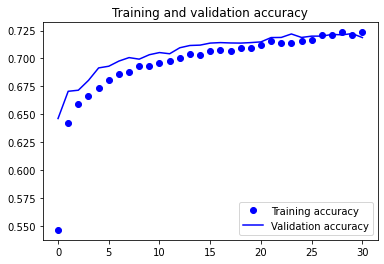

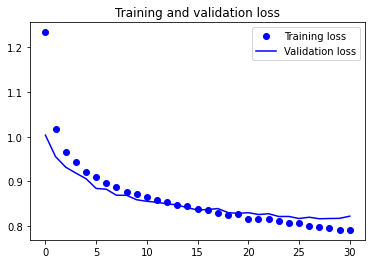

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss', keras_layer=hub.KerasLayer)
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 22s 84ms/step - loss: 0.6149 - accuracy: 0.7849
Loss on test set: 0.6148972511291504
Accuracy on test set: 0.7849282026290894
262/262 [==============================] - 21s 79ms/step
                     precision    recall  f1-score   support

                age     0.9246    0.9436    0.9340      1560
          ethnicity     0.8752    0.9025    0.8887      1570
             gender     0.8277    0.7599    0.7923      1441
           religion     0.8970    0.9123    0.9046      1585
other_cyberbullying     0.4550    0.5760    0.5084       974
  not_cyberbullying     0.5821    0.4642    0.5165      1230

           accuracy                         0.7849      8360
          macro avg     0.7603    0.7598    0.7574      8360
       weighted avg     0.7883    0.7849    0.7845      8360



262/262 [==============================] - 21s 79ms/step


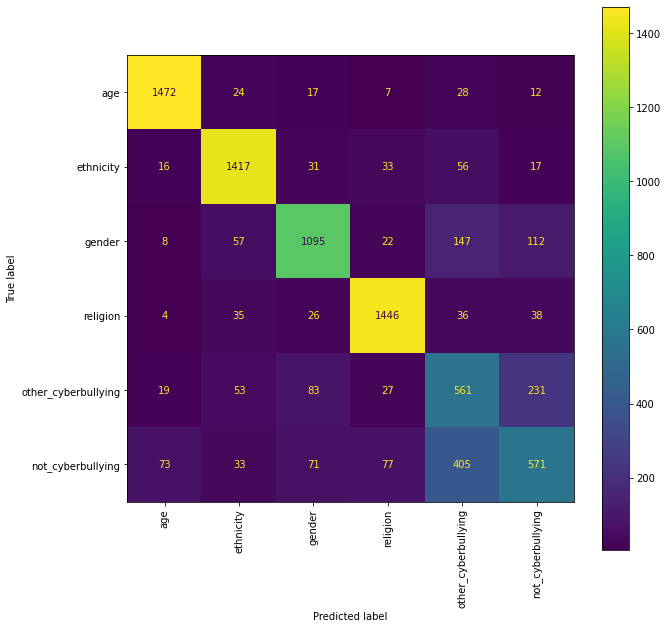

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## Fine Tuning

In [ ]:
model = models.load_model(MODELS_PATH + "/BertBase_Freezed/BertBase_Freezed.h5", custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
model.get_layer("BERT_encoder").trainable = True
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "BertBase_Freezed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                       

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.6963
Epoch 1: val_loss improved from inf to 0.68197, saving model to model/BertBase_Freezed_finetuned.h5
109/109 [==============================] - 350s 3s/step - loss: 0.9904 - accuracy: 0.6963 - val_loss: 0.6820 - val_accuracy: 0.7736
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.7888
Epoch 2: val_loss improved from 0.68197 to 0.65407, saving model to model/BertBase_Freezed_finetuned.h5
109/109 [==============================] - 343s 3s/step - loss: 0.6360 - accuracy: 0.7888 - val_loss: 0.6541 - val_accuracy: 0.7838
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.5453 - accuracy: 0.8230
Epoch 3: val_loss did not improve from 0.65407
109/109 [==============================] - 345s 3s/step - loss: 0.5453 - accuracy: 0.8230 - val_loss: 0.6706 - val_accuracy: 0.7813
Epoch 4/50
109/109 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: ram://1e564fdb-47e6-4363-a754-5f8113e6bd60/assets


INFO:tensorflow:Assets written to: ram://1e564fdb-47e6-4363-a754-5f8113e6bd60/assets


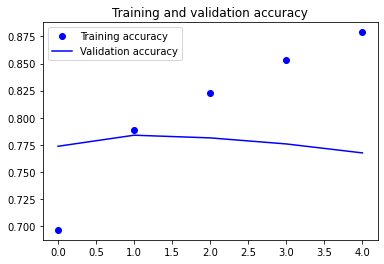

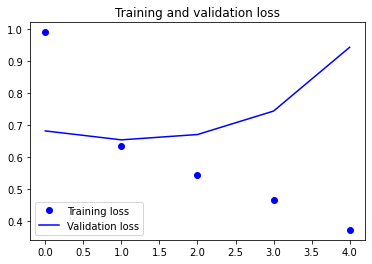

In [ ]:
model, history = run_model(model, model.name + "_finetuned", x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss', keras_layer=hub.KerasLayer)
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 24s 88ms/step - loss: 0.3911 - accuracy: 0.8626
Loss on test set: 0.3910590410232544
Accuracy on test set: 0.8625597953796387
262/262 [==============================] - 22s 82ms/step
                     precision    recall  f1-score   support

                age     0.9655    0.9692    0.9674      1560
          ethnicity     0.9878    0.9809    0.9843      1570
             gender     0.9029    0.8779    0.8902      1441
           religion     0.9632    0.9590    0.9611      1585
other_cyberbullying     0.5866    0.6016    0.5940       974
  not_cyberbullying     0.6269    0.6407    0.6337      1230

           accuracy                         0.8626      8360
          macro avg     0.8388    0.8382    0.8385      8360
       weighted avg     0.8645    0.8626    0.8635      8360



291/291 [==============================] - 24s 81ms/step


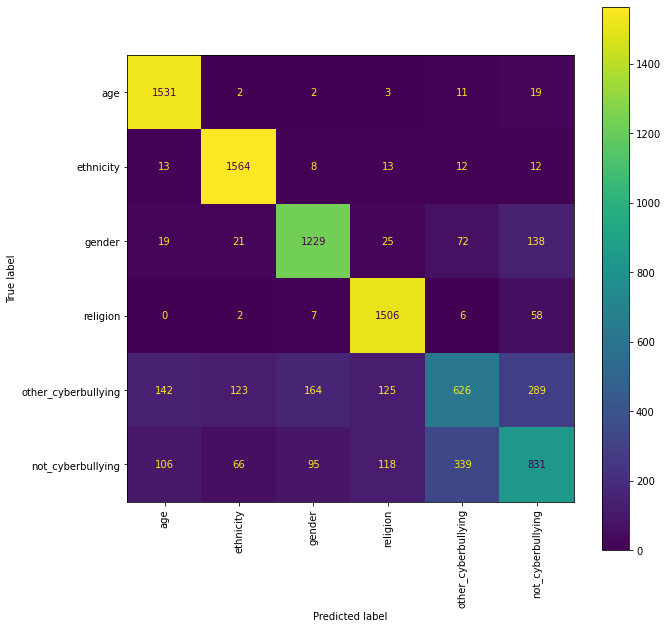

In [ ]:
plot_confusionmatrix(model, x_val, y_val)

#Bert model with increased Dropout

In [ ]:
BERT_MODEL="https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
BERT_PREPROCESS_MODEL="https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
text_input = layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(BERT_PREPROCESS_MODEL, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
  
encoder = hub.KerasLayer(BERT_MODEL, trainable=False, name='BERT_encoder_dropout035')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = layers.Dropout(0.35)(net)
net = layers.Dense(128,activation = "relu")(net)
net = layers.Dropout(0.35)(net)
net = layers.Dense(len(CLASSES), activation="softmax", name='classifier')(net)
  
model = tf.keras.Model(text_input, net, name = "BertBase_Freezed_dropout035")

model = compile_model(model, loss="sparse_categorical_crossentropy", learning_rate=0.001)
model.summary()

Model: "BertBase_Freezed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                       

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.3537 - accuracy: 0.4885
Epoch 1: val_loss improved from inf to 1.02201, saving model to model/BertBase_Freezed.h5
109/109 [==============================] - 305s 3s/step - loss: 1.3537 - accuracy: 0.4885 - val_loss: 1.0220 - val_accuracy: 0.6430
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 1.1091 - accuracy: 0.5973
Epoch 2: val_loss improved from 1.02201 to 0.97404, saving model to model/BertBase_Freezed.h5
109/109 [==============================] - 299s 3s/step - loss: 1.1091 - accuracy: 0.5973 - val_loss: 0.9740 - val_accuracy: 0.6612
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 1.0579 - accuracy: 0.6184
Epoch 3: val_loss improved from 0.97404 to 0.94131, saving model to model/BertBase_Freezed.h5
109/109 [==============================] - 298s 3s/step - loss: 1.0579 - accuracy: 0.6184 - val_loss: 0.9413 - val_accuracy: 0.6734
Epoch 4/50
109/109 [==================

INFO:tensorflow:Assets written to: ram://67fa7781-3bb8-4e4a-8651-5eeaa31d3bfa/assets


INFO:tensorflow:Assets written to: ram://67fa7781-3bb8-4e4a-8651-5eeaa31d3bfa/assets


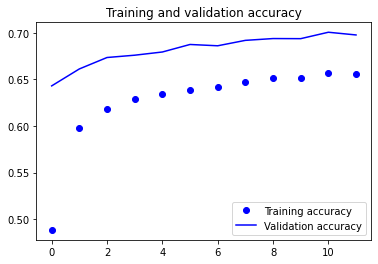

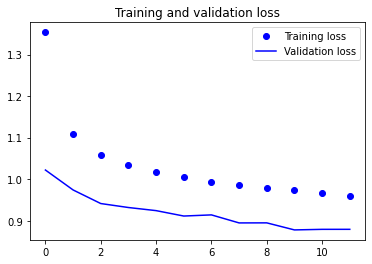

In [ ]:
model, history = run_model(model, model.name, x_train, y_train, x_val, y_val, 50, patience=2, monitor='val_loss', keras_layer=hub.KerasLayer)
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 23s 86ms/step - loss: 0.6851 - accuracy: 0.7586
Loss on test set: 0.6851325035095215
Accuracy on test set: 0.7586124539375305
262/262 [==============================] - 21s 80ms/step
                     precision    recall  f1-score   support

                age     0.8917    0.9449    0.9175      1560
          ethnicity     0.8347    0.8713    0.8526      1570
             gender     0.8160    0.6801    0.7419      1441
           religion     0.8622    0.8997    0.8805      1585
other_cyberbullying     0.4425    0.4743    0.4579       974
  not_cyberbullying     0.5406    0.5138    0.5269      1230

           accuracy                         0.7586      8360
          macro avg     0.7313    0.7307    0.7295      8360
       weighted avg     0.7584    0.7586    0.7570      8360



262/262 [==============================] - 21s 80ms/step


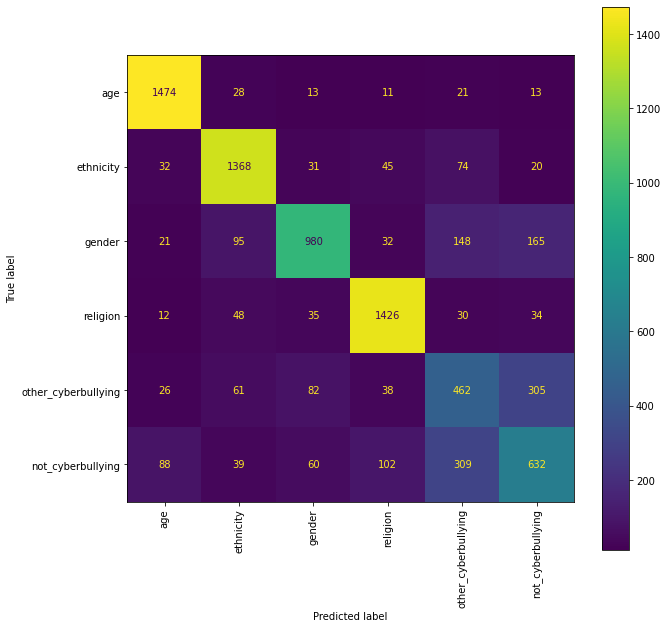

In [ ]:
plot_confusionmatrix(model, x_test, y_test)

## Fine Tuning

In [ ]:
model.get_layer("BERT_encoder_dropout035").trainable = True
model = compile_model(model, loss="sparse_categorical_crossentropy")
model.summary()

Model: "BertBase_Freezed"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                           

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 0.9074 - accuracy: 0.7172
Epoch 1: val_loss improved from inf to 0.69580, saving model to model/BertBase_Freezed_finetuned.h5
109/109 [==============================] - 358s 3s/step - loss: 0.9074 - accuracy: 0.7172 - val_loss: 0.6958 - val_accuracy: 0.7697
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.7837
Epoch 2: val_loss improved from 0.69580 to 0.67012, saving model to model/BertBase_Freezed_finetuned.h5
109/109 [==============================] - 349s 3s/step - loss: 0.6687 - accuracy: 0.7837 - val_loss: 0.6701 - val_accuracy: 0.7817
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.8134
Epoch 3: val_loss did not improve from 0.67012
109/109 [==============================] - 350s 3s/step - loss: 0.5898 - accuracy: 0.8134 - val_loss: 0.6873 - val_accuracy: 0.7768
Epoch 4/50
109/109 [==============================] - ETA: 0s - l

INFO:tensorflow:Assets written to: ram://9c68caec-6cf2-43b7-ad14-68ce1e811326/assets


INFO:tensorflow:Assets written to: ram://9c68caec-6cf2-43b7-ad14-68ce1e811326/assets


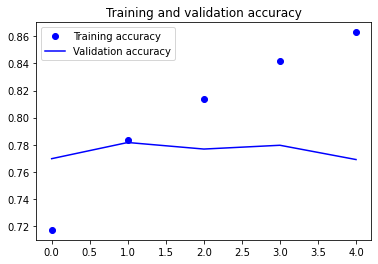

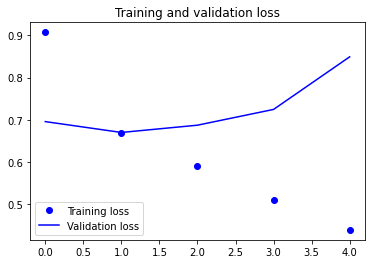

In [ ]:
model, history = run_model(model, model.name + "_finetuned", x_train, y_train, x_val, y_val, 50, patience=3, monitor='val_loss', keras_layer=hub.KerasLayer)
plot_accuracy_and_loss_history(history)

In [ ]:
evaluate_model(model, x_test, y_test)

262/262 [==============================] - 24s 88ms/step - loss: 0.4010 - accuracy: 0.8572
Loss on test set: 0.4009633958339691
Accuracy on test set: 0.8571770191192627
262/262 [==============================] - 21s 80ms/step
                     precision    recall  f1-score   support

                age     0.9422    0.9821    0.9617      1560
          ethnicity     0.9916    0.9758    0.9836      1570
             gender     0.8854    0.8897    0.8875      1441
           religion     0.9489    0.9609    0.9549      1585
other_cyberbullying     0.5904    0.5832    0.5868       974
  not_cyberbullying     0.6210    0.5927    0.6065      1230

           accuracy                         0.8572      8360
          macro avg     0.8299    0.8307    0.8302      8360
       weighted avg     0.8547    0.8572    0.8558      8360



291/291 [==============================] - 23s 80ms/step


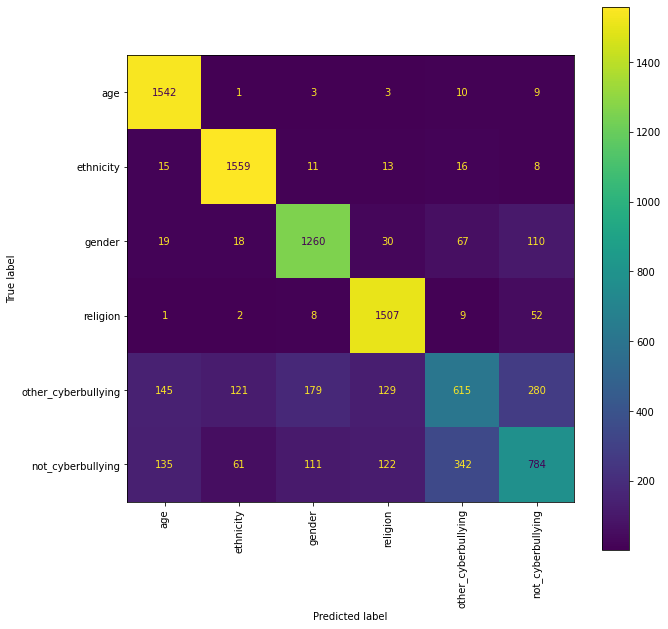

In [ ]:
plot_confusionmatrix(model, x_val, y_val)

Now we will save the results of the best model found, the one finetuned without the increased dropout, in order to use them for the ensemble model.

In [14]:
bert_model = models.load_model(MODELS_PATH + '/BertBase_Freezed_finetuned/BertBase_Freezed_finetuned.h5', custom_objects={'KerasLayer':hub.KerasLayer})

bert_scores_test = bert_model.predict(x_test)
bert_scores_val = bert_model.predict(x_val)

saveObject(bert_scores_test, DRIVE_DIR + "/Results/bert_scores_test")
saveObject(bert_scores_val, DRIVE_DIR + "/Results/bert_scores_val")

291/291 [==============================] - 27s 92ms/step
Saving /content/gdrive/Shareddrives/CyberBullyingClassification/Results/bert_scores_test.pkl
Saving /content/gdrive/Shareddrives/CyberBullyingClassification/Results/bert_scores_val.pkl
